In [92]:
import sys
import os
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby
from copy import deepcopy


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
from utils.os_utils import smart_makedirs
import networkx as nx
from debruijn_graph import DeBruijnGraph

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and correct gaps

In [10]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = '/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa'


lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [11]:
monomer_strings = {r_id: record.string for r_id, record in lrd_report.records.items()}
len(monomer_strings)

471

In [12]:
def filter_strings(monomer_strings, max_gap=0.05, max_lowercase=0.01):
    filtered_strings = {}
    for r_id, string in monomer_strings.items():
        ngaps = Counter(string)['=']
        lowercase = [s.islower() for s in string]
        if np.mean(lowercase) > max_lowercase:
            continue
        if ngaps / len(string) <= max_gap:
            filtered_strings[r_id] = string
    return filtered_strings

In [13]:
monomer_strings = filter_strings(monomer_strings)
len(monomer_strings)

407

In [14]:
def get_ma(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def trim_read(monomer_string, max_gap, ma_window):
    is_gap = [c == '=' for c in monomer_string]
    ma = get_ma(is_gap, N=ma_window)
    l = 0
    while l < len(ma) and ma[l] > max_gap:
        l += 1
    r = len(ma) - 1
    while r >= 0 and ma[r] > max_gap:
        r -= 1
    trimmed_read = monomer_string[l:r+1+ma_window]
    trimmed_read = trimmed_read.strip('=')
    return trimmed_read

def trim_reads(monomer_strings, max_gap=0.2, ma_window=30):
    trimmed_reads = {}
    for r_id, monomer_string in monomer_strings.items():
        trimmed_read = trim_read(monomer_string, max_gap=max_gap, ma_window=ma_window)
        trimmed_reads[r_id] = trimmed_read
    return trimmed_reads

In [15]:
monomer_strings = trim_reads(monomer_strings)
len(monomer_strings)

407

In [16]:
def get_frequent_kmers(strings, k, min_mult=5):
    all_kmers = Counter()
    read_kmer_locations = defaultdict(list)
    for r_id, string in strings.items():
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                read_kmer_locations[kmer].append((r_id, i))
                
    frequent_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                      if cnt >= min_mult}
    frequent_kmers_read_pos = {kmer: read_kmer_locations[kmer] for kmer in frequent_kmers}
    return frequent_kmers, frequent_kmers_read_pos

In [10]:
frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=3, min_mult=1000)
db = DeBruijnGraph(k=3)
db.add_kmers(frequent_kmers, coverage=frequent_kmers)

hors, _ = db.get_contigs()

def correct_gaps(monomer_strings, hors, max_gap=0.7, nhor=5):
    corrected_strings = {}
    for r_id, monomer_string in monomer_strings.items():
            corrected_string = list(monomer_string)
            for single_hor in hors:
                for i_nhor in range(1, nhor+1):
                    hor = single_hor * i_nhor
                    hor_len = len(hor)
                    for i in range(len(monomer_string)-hor_len+1):
                        kmer = monomer_string[i:i+hor_len]
                        gap_cnt = Counter(kmer)['=']
                        if gap_cnt == 0 or gap_cnt / hor_len > max_gap:
                            continue
                        hd, _ = hamming_distance(kmer, hor, match_char=set('='))
                        if hd == 0:
                            # print(hor)
                            # print(kmer)
                            # print("")
                            corrected_string[i:i+hor_len] = list(hor)
                        
            corrected_strings[r_id] = ''.join(corrected_string)
    return corrected_strings

monomer_strings = correct_gaps(monomer_strings, hors)

In [11]:
def get_ngaps(strings):
    ngaps = 0
    for r_id, string in strings.items():
        r_ngaps = Counter(string)['=']
        if r_ngaps >= 5:
            mstring = string.lower()
            mstring = mstring.replace('=', '|')
            # print(r_id)
            # print(mstring)
            # print("")
        ngaps += r_ngaps
    return ngaps


ngaps = get_ngaps(monomer_strings)
print(ngaps)

152


In [12]:
def get_read_coverage(frequent_kmers_read_pos, monomer_strings, k):
    coverage = {}
    for r_id, string in monomer_strings.items():
        coverage[r_id] = [0] * (len(string) + 1)
    for pairs in frequent_kmers_read_pos.values():
        for r_id, pos in pairs:
            coverage[r_id][pos] += 1
            coverage[r_id][pos+k] -= 1
    for r_id in coverage:
        coverage[r_id] = np.cumsum(coverage[r_id])
        coverage[r_id] = coverage[r_id][:-1]
    return coverage

def find_zero_cov(coverage):
    all_zero_cov = {}
    for r_id in coverage:
        zero_cov_flatten = np.where(coverage[r_id] == 0)[0]
        if len(zero_cov_flatten) == 0:
            all_zero_cov[r_id] = []
            continue
        zero_cov = []
        zero_cov.append([zero_cov_flatten[0]])
        for pos in zero_cov_flatten[1:]:
            if pos == zero_cov[-1][-1] + 1:
                zero_cov[-1].append(pos)
            else:
                zero_cov.append([pos])
        
        all_zero_cov[r_id] = [(x[0], x[-1]) for x in zero_cov]
        
    return all_zero_cov

def find_path_debr(zero_cov, read_seq, r_id, k, db,
                   max_len=1000, min_len=1, min_overlap=3, max_overlap=30, max_dist=1):
    k -= 1
    results = {}
    corrected_seq = list(read_seq)
    for st, en in zero_cov[::-1]:
        if st < k or en > len(read_seq) - 1 - k or en-st+1 > max_len or en-st+1 < min_len:
            # results[(st, en)] = '-'
            continue
        # print(r_id, st, en)
        st_kmer, en_kmer = read_seq[st-k:st], read_seq[en+1:en+1+k]
        # assert st_kmer in frequent_kmers
        # assert en_kmer in frequent_kmers
        # assert read_seq[st-k+1:st+1] not in frequent_kmers
        # assert read_seq[en:en+k] not in frequent_kmers
        # assert st_kmer in db.graph.nodes

        u = st_kmer
        kmers = [u]
        while u != en_kmer and len(kmers) < 2*k:
            u_node = db.node_mapping[u]
            out_edges = list(db.graph.out_edges(u_node))
            # print(list(db.graph.nodes(data=True))[0])
            # print(u, len(db.graph.in_edges(u_node)), len(out_edges))
            # print(out_edges)
            if len(out_edges) == 1:
                edge = out_edges[0]
                assert edge[0] == u_node
                u_node = edge[1]
                u = db.rev_node_mapping[u_node]
                kmers.append(u)
            else:
                break
            
        if len(kmers) < min_overlap + 1:
            # results[(st, en)] = '-'
            # print(kmers)
            continue

        # print(len(kmers))
        extension = [kmer[-1] for kmer in kmers[1:]]
        extension = ''.join(extension)
        read_segment = read_seq[en+1:en+len(extension)]
        # print(extension)
        # print(read_segment)
        
        ident = identity_shift(extension[:max_overlap],
                               read_segment[:max_overlap],
                               min_overlap=min_overlap,
                               match_char=set('='))
        # print(ident)
        if ident['id'] == 1 and ident['shift'] is not None:
            # print(ident)
            correction = extension[:ident['shift']]
            if abs(len(correction) - (en-st+1)) > 10:
                # results[(st, en)] = '-'
                continue
            print(read_seq[st:en+1], read_seq[st-5:en+6])
            print(correction, len(correction))
            print("")
            results[(st, en)] = (read_seq[st:en+1], correction)
            corrected_seq[st:en+1] = list(correction)
    corrected_seq = ''.join(corrected_seq)
    return results, corrected_seq


def correct_seq(monomer_strings, k, min_mult=10):
    frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=k, min_mult=min_mult)
    db = DeBruijnGraph(k=k)
    db.add_kmers(frequent_kmers, coverage=frequent_kmers)
    coverage = get_read_coverage(frequent_kmers_read_pos=frequent_kmers_read_pos,
                                 monomer_strings=monomer_strings,
                                 k=k)
    zero_cov = find_zero_cov(coverage=coverage)
    
    all_corrections = {}
    corrected_seqs = {}
    for r_id in zero_cov:
        all_corrections[r_id], corrected_seqs[r_id] = find_path_debr(zero_cov[r_id],
                                                              monomer_strings[r_id],
                                                              r_id=r_id,
                                                              k=k,
                                                              db=db)
    return all_corrections, corrected_seqs


def correct_reads(monomer_strings, min_k=10, max_k=200, niter=1):
    corrected_seqs = monomer_strings
    for k in range(min_k, max_k):
        for i in range(niter):
            print(k, i)
            all_corrections, corrected_seqs = correct_seq(corrected_seqs, k=k)
            for r_id, corrections in all_corrections.items():
                if len(corrections):
                    print(r_id, corrections)
    return corrected_seqs

In [13]:
monomer_strings = correct_reads(monomer_strings)

10 0
== DEFGH==LMNOP
IJK 3

= NOPQL=NOPQR
M 1

B EFGHIBKLMNO
J 1

= BCGHI=KLMNO
J 1

== ADEFG==JKLMN
HI 2

= ADEFG=IJKLM
H 1

F BFGHIFKLMNO
J 1

C FGHIJCLMNOP
K 1

EFG= RABCGEFG=IJKLM
H 1

= QRADE=GHIJK
F 1

343a21b5-fd1f-486f-bf0f-5d4cabcda6e9 {(620, 621): ('==', 'IJK')}
42da64e4-e647-4426-b497-cda32cd3ca28 {(301, 301): ('=', 'M')}
46a4165e-6315-4339-9d4e-3af1ca00b3fc {(902, 902): ('B', 'J')}
647c3a75-dc83-414f-b342-6df41c7e59b7 {(398, 398): ('=', 'J')}
8e85dd90-8045-4df1-ba7b-b6b576deaa4d {(408, 409): ('==', 'HI')}
9e50bfee-7cce-4e72-9557-e40959c5fc51 {(29, 29): ('=', 'H')}
9ec8cb0b-c287-4823-9612-96befabdab60 {(84, 84): ('F', 'J')}
c210d178-68e0-4389-ad0a-5009d96c9d9c {(598, 598): ('C', 'K')}
c7e3bd82-2f61-4662-b255-ca9b66e20b95 {(130, 133): ('EFG=', 'H')}
f9474aed-548b-482b-a569-95d17bea44ba {(162, 162): ('=', 'F')}
10 1
11 0
11 1
12 0
=== DEFGH===MNOPQ
IJKL 4

= GHIJK=MNOPQ
L 1

= FGHIJ=MNOPQ
KL 2

H HIJKLHNOPQR
M 1

1d0706f6-cc39-4a05-a4fd-2ee7e1674457 {(452, 454): ('===', 'IJKL'

277 1
278 0
278 1
279 0
279 1
280 0
280 1
281 0
281 1
282 0
282 1
283 0
283 1
284 0
284 1
285 0
285 1
286 0
286 1
287 0
287 1
288 0
288 1
289 0
289 1
290 0
290 1
291 0
291 1
292 0
292 1
293 0
293 1
294 0
AB QRABCABFGHIJ
DE 2

ab3606e5-0041-4da0-9db5-6a30aedd8b83 {(603, 604): ('AB', 'DE')}
294 1
295 0
295 1
296 0
296 1
297 0
D QRABCDHIJKL
G 1

03e1fc3d-8e77-4170-94e1-3711db044f8b {(331, 331): ('D', 'G')}
297 1
298 0
298 1
299 0
299 1


In [14]:
ngaps = get_ngaps(monomer_strings)
print(ngaps)

104


# Iterative construction

In [40]:
def iterative_graph(monomer_strings, min_k, max_k, outdir, min_mult=5, step=1, starting_graph=None):
    smart_makedirs(outdir)
    
    dbs, all_contigs = {}, {}
    input_strings = monomer_strings.copy()
    
    if starting_graph is not None:
        contigs, contig_paths = starting_graph.get_contigs()
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{min_k}_i{i}_j{j}'] = contigs[i]

    for k in range(min_k, max_k+1, step):
        print(f'\nk={k}')
        # print(len(input_strings))
        frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(input_strings, k=k, min_mult=min_mult)
        print(f'#frequent kmers = {len(frequent_kmers)}')
        db = DeBruijnGraph(k=k)
        db.add_kmers(frequent_kmers, coverage=frequent_kmers)

        # lens = sorted((len(contig), coverage) for contig, coverage in zip(contigs, coverages))[::-1]
        # long_edges = [x for x in lens if x[1] >= 50]
        
        db.collapse_nonbranching_paths()
        if nx.number_weakly_connected_components(db.graph) > 1:
            print(f'#cc = {nx.number_weakly_connected_components(db.graph)}')
            for cc in nx.weakly_connected_components(db.graph):
                print(len(cc))
            # break
        dbs[k] = db
        
        dot_file = os.path.join(outdir, f'db_k{k}.dot')
        pdf_file = os.path.join(outdir, f'db_k{k}.pdf')
        nx.drawing.nx_pydot.write_dot(db.graph, dot_file)
        !dot -Tpdf {dot_file} -o {pdf_file}
        
        
        contigs, contig_paths = db.get_contigs()
        all_contigs[k] = contigs

        input_strings = monomer_strings.copy()
        # print(len(input_strings))
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{k}_i{i}_j{j}'] = contigs[i]
        # print(len(input_strings))
    
    return all_contigs, dbs

In [41]:
min_k, max_k = 10, 513
contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k,
                               outdir='/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191112/db_wo_error_corr')


k=10
#frequent kmers = 98

k=11
#frequent kmers = 106

k=12
#frequent kmers = 113

k=13
#frequent kmers = 121

k=14
#frequent kmers = 129

k=15
#frequent kmers = 137

k=16
#frequent kmers = 147

k=17
#frequent kmers = 158

k=18
#frequent kmers = 171

k=19
#frequent kmers = 185

k=20
#frequent kmers = 199

k=21
#frequent kmers = 213

k=22
#frequent kmers = 227

k=23
#frequent kmers = 241

k=24
#frequent kmers = 255

k=25
#frequent kmers = 268
#cc = 2
26
2

k=26
#frequent kmers = 281
#cc = 2
25
2

k=27
#frequent kmers = 294
#cc = 2
28
2

k=28
#frequent kmers = 307
#cc = 2
27
2

k=29
#frequent kmers = 320
#cc = 2
27
2

k=30
#frequent kmers = 333

k=31
#frequent kmers = 347

k=32
#frequent kmers = 362

k=33
#frequent kmers = 376

k=34
#frequent kmers = 392

k=35
#frequent kmers = 409

k=36
#frequent kmers = 428

k=37
#frequent kmers = 447

k=38
#frequent kmers = 466

k=39
#frequent kmers = 485

k=40
#frequent kmers = 504

k=41
#frequent kmers = 523

k=42
#frequent kmers = 542

k=43
#frequ


k=266
#frequent kmers = 12893

k=267
#frequent kmers = 12915

k=268
#frequent kmers = 12937

k=269
#frequent kmers = 12959

k=270
#frequent kmers = 12981

k=271
#frequent kmers = 13003

k=272
#frequent kmers = 13025

k=273
#frequent kmers = 13047

k=274
#frequent kmers = 13069

k=275
#frequent kmers = 13091

k=276
#frequent kmers = 13113

k=277
#frequent kmers = 13135

k=278
#frequent kmers = 13155

k=279
#frequent kmers = 13175

k=280
#frequent kmers = 13195

k=281
#frequent kmers = 13215

k=282
#frequent kmers = 13235

k=283
#frequent kmers = 13255

k=284
#frequent kmers = 13274

k=285
#frequent kmers = 13292

k=286
#frequent kmers = 13310

k=287
#frequent kmers = 13329

k=288
#frequent kmers = 13348

k=289
#frequent kmers = 13367

k=290
#frequent kmers = 13386

k=291
#frequent kmers = 13405

k=292
#frequent kmers = 13424

k=293
#frequent kmers = 13442

k=294
#frequent kmers = 13460

k=295
#frequent kmers = 13478

k=296
#frequent kmers = 13496

k=297
#frequent kmers = 13513

k=298
#

In [ ]:
# After error correction i could get to max_k = 634
# min_k, max_k = 10, 634
# contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k)

In [42]:
# db = dbs[max(dbs.keys())]
# db = dbs[634]
# db = dbs2[500]
db = dbs[511]


assert nx.number_weakly_connected_components(db.graph) == 1

# contigs, contig_paths = db.get_contigs()

In [27]:
len(contigs)

24

In [28]:
contig_lens = sorted(len(contig) for contig in contigs)
print(contig_lens)

[594, 630, 736, 771, 958, 1053, 1068, 1104, 1116, 1266, 1266, 1281, 1422, 1468, 1770, 1869, 2265, 2283, 2367, 3117, 3249, 3552, 4322, 4340]


In [25]:
edges, coverage = db.get_edges()

In [26]:
edge_lens = sorted(len(edge) for edge in edges)
print(edge_lens)

[636, 637, 644, 658, 658, 658, 819, 934, 939, 991, 1251, 1269, 1566, 1685, 1899, 3932, 4452, 4476]


In [29]:
nx.drawing.nx_pydot.write_dot(db.graph, 'db.dot')

In [28]:
#nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(db.graph)

#nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
#                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

In [90]:
def map_reads(monomer_strings, db, db_index=None):
    if db_index is None:
        db_index = db.index_edges()
    mapping = {}
    db_edges = list(db.graph.edges(keys=True))
    for r_id, string in monomer_strings.items():
        split_strings = list(filter(lambda string: len(string), string.split('=')))
        split_lens = [0] + [len(split_string) for split_string in split_strings]
        cum_split_lens = np.cumsum(split_lens)
        read_coords = []
        for split_ind, split_string in enumerate(split_strings):
            for i in range(len(split_string)-db.k+1):
                kmer = split_string[i:i+db.k]
                if kmer in db_index[len(kmer)]:
                    read_coords.append(db_index[len(kmer)][kmer])
        
        path = [x[0] for x in read_coords]
        path = [x[0] for x in groupby(path)]
        path = [db_edges[edge_ind] for edge_ind in path]
        
        valid_path = True
        for e1, e2 in zip(path[:-1], path[1:]):
            if e1[1] != e2[0]:
                valid_path = False
                break
        if len(read_coords):
            mapping[r_id] = (read_coords[0], read_coords[-1], valid_path, path)
        else:
            mapping[r_id] = None
    return mapping

In [21]:
mappings = map_reads(monomer_strings, db)

In [22]:
print(np.mean([read_mapping is not None for read_mapping in mappings.values()]))
print(np.mean([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))
print(np.sum([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))

for r_id, read_mapping in mappings.items():
    if read_mapping is not None and read_mapping[2]:
        print(r_id, len(monomer_strings[r_id]), len(monomer_strings[r_id]) * 171,
              len(db.get_path(read_mapping[-1])), read_mapping)

0.6560196560196561
0.9101123595505618
243
00739941-c14c-40bd-9fad-fabff753795b 798 136458 1457 ((11, 190), (0, 175), True, [(3224, 7, 0), (7, 6183, 0)])
01f80610-395e-4ef8-93d0-526989b8cb53 1214 207594 2493 ((28, 771), (28, 1480), True, [(8962, 6647, 0)])
04b2f961-f6b4-438d-9a64-83dbd6049ffc 799 136629 1778 ((27, 662), (27, 961), True, [(8962, 13888, 0)])
0540aa3e-f34b-4e74-a5e5-884b69594a0d 641 109611 1778 ((27, 306), (27, 447), True, [(8962, 13888, 0)])
05a4fa6a-38b1-40d6-916e-886ad1fb050b 1032 176472 3331 ((7, 1225), (1, 181), True, [(2222, 915, 0), (915, 8627, 0)])
05c5a912-42ad-4a57-ae81-0a318dc8c6b7 865 147915 2031 ((1, 733), (1, 803), True, [(915, 8627, 0)])
079aa8c8-90a4-4fe8-af37-d9170f7d82b7 983 168093 2493 ((28, 265), (28, 742), True, [(8962, 6647, 0)])
08a68948-5d96-4ed2-9632-c86d0200d914 1071 183141 1255 ((20, 8), (5, 307), True, [(7678, 1652, 0), (1652, 1839, 0), (1839, 1913, 0), (1913, 11129, 0)])
0aca72fc-0a1e-416a-beb5-6b4bde55eb81 778 133038 1799 ((7, 0), (7, 213), Tr

In [34]:
def filter_mappings(mappings, db):
    filtered_mappings = {}
    contigs, contig_paths = db.get_contigs()
    for r_id, read_mapping in mappings.items():
        if read_mapping is None or not read_mapping[-2]:
            continue
        read_mapping = read_mapping[-1]
        rm_len = len(read_mapping)
        if rm_len == 1:
            continue
        in_contig = False
        for path in contig_paths:
            path = list(path)
            for i in range(len(path)-rm_len+1):
                subpath = path[i:i+rm_len]
                # print(subpath)
                # print(read_mapping)
                if subpath == read_mapping:
                    in_contig = True
                    break
            if in_contig:
                break
        if not in_contig:
            filtered_mappings[r_id] = read_mapping
            # print(r_id, read_mapping)
        else:
            pass
            # print(r_id, read_mapping)
    return filtered_mappings

In [35]:
scaffolding_reads = filter_mappings(mappings, db)

In [36]:
len(scaffolding_reads)

31

In [37]:
def get_scaffold_links(scaffolding_reads, db):
    scaffolds = defaultdict(list)
    contigs, contig_paths = db.get_contigs()
    for r_id, scaffolding_read in scaffolding_reads.items():
        best_lo, best_lo_len, best_lo_shift = None, 0, 0
        best_ro, best_ro_len, best_ro_shift = None, 0, 0
        
        for i, path in enumerate(contig_paths):
            l_overlap = identity_shift(path, scaffolding_read, min_overlap=1)
            r_overlap = identity_shift(scaffolding_read, path, min_overlap=1)
            if l_overlap['id'] == 1 and len(l_overlap['alt_shifts']) == 0 \
                    and l_overlap['len'] >= best_lo_len \
                    and l_overlap['shift'] + len(scaffolding_read) > len(path) \
                    and l_overlap['shift'] >= 1:
                best_lo = list(path)
                best_lo_len = l_overlap['len']
                best_lo_shift = l_overlap['shift']
            
            if r_overlap['id'] == 1 and len(r_overlap['alt_shifts']) == 0 \
                    and r_overlap['len'] >= best_ro_len \
                    and r_overlap['shift'] + len(path) > len(scaffolding_read) \
                    and r_overlap['shift'] >= 1:
                best_ro = list(path)
                best_ro_len = r_overlap['len']
                best_ro_shift = r_overlap['shift']
            
        if best_lo is not None and best_ro is not None:
            scaffold = best_lo[:best_lo_shift] + scaffolding_read[:best_ro_shift] + best_ro
            scaffold = tuple(scaffold)
            scaffolds[scaffold].append(r_id)
#             print('left')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_lo)
#             print("")
#             print('right')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_ro)
#             print("")
#             print("scaffold:", scaffold)
#             print(len(db.get_path(scaffold)))
#             print("")
    
    return scaffolds
            

In [38]:
scaffolds = get_scaffold_links(scaffolding_reads, db)

In [41]:
for scaffold in scaffolds:
    print(scaffold, len(db.get_path(scaffold)))

((10200, 6486, 0), (6486, 6792, 0), (6792, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0)) 6008
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0), (9036, 4263, 0), (4263, 2694, 0)) 9667
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 1), (9036, 4263, 0), (4263, 2694, 0)) 9649


# Comparison 2 K assembly

In [244]:
from string import ascii_uppercase

In [245]:
man_assembly_fn = "CEN6_ManVERSION3.tsv"

units = []
with open(man_assembly_fn) as f:
    for line in f:
        line = line.strip().split('\t')
        st, en = int(line[-2]), int(line[-1])
        if en < 17:
            en -= 1
        units.append((st, en))

In [246]:
def units2monomers(units):
    monomers = []
    for (s, e) in units:
        monomers.append(ascii_uppercase[s:e+1])
    monomers = ''.join(monomers)
    return monomers

In [247]:
ref_monomers = units2monomers(units)

In [252]:
def get_cov(ref_monomers, seqs, max_ed=10000):
    coverage = [0] * (len(ref_monomers)+1)
    for r_id, seq in seqs.items():
        alignment = edlib.align(seq,
                                ref_monomers,
                                mode='HW',
                                task='locations',
                                k=max_ed)
        print(alignment, np.diff(alignment['locations']))
        loc = alignment['locations']
        if loc is None or len(loc) != 1:
            continue
        else:
            loc = loc[0]
        coverage[loc[0]] += 1
        coverage[loc[1]+1] -= 1
    coverage = np.cumsum(coverage)
    return coverage

In [253]:
ref_coverage = get_cov(ref_monomers, {i: contig for i, contig in enumerate(contigs)})

{'editDistance': 36, 'alphabetLength': 19, 'locations': [(0, 1693)], 'cigar': None} [[1693]]
{'editDistance': 90, 'alphabetLength': 18, 'locations': [(810, 11507)], 'cigar': None} [[10697]]
{'editDistance': 21, 'alphabetLength': 19, 'locations': [(12201, 17751)], 'cigar': None} [[5550]]


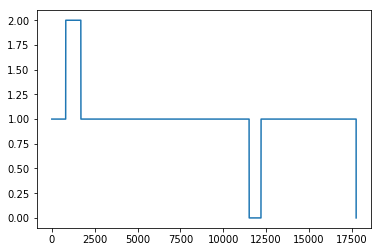

In [250]:
plt.plot(ref_coverage)

In [251]:
[len(contig) for contig in contigs]

[1726, 10627, 5563]

# Investigation of 303-304

In [66]:
db465 = dbs[465]
db466 = dbs[466]

In [73]:
db465.graph.edges[3736, 7, 0]['edge_kmer']

'DEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQ'

In [74]:
db466.graph.edges[3721, 7, 0]['edge_kmer']

'CDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQR'

In [87]:
db466.graph.edges[3724, 3721, 0]['edge_kmer'][-465:]

'CDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQ'

In [88]:
db466.graph.edges[6918, 7080, 0]['edge_kmer'][-465:]

'ADEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQ'

# "Complex" vertices

In [121]:
db = dbs[15]
nx.number_weakly_connected_components(db.graph)

1

In [126]:
def get_complex_node(graph):
    cnt = 0
    for node in graph.nodes():
        indegree, outdegree = graph.in_degree(node), graph.out_degree(node)
        if indegree > 1 and outdegree > 1:
            cnt += 1
    return cnt

In [128]:
for i, db in dbs.items():
    print(i, get_complex_node(db.graph))

10 2
11 2
12 1
13 2
14 3
15 3
16 4
17 5
18 4
19 2
20 2
21 2
22 2
23 1
24 1
25 2
26 3
27 0
28 1
29 1
30 3
31 5
32 6
33 6
34 4
35 3
36 3
37 1
38 2
39 2
40 2
41 1
42 0
43 2
44 3
45 2
46 2
47 1
48 2
49 7
50 4
51 7
52 4
53 3
54 3
55 1
56 2
57 2
58 1
59 0
60 0
61 3
62 3
63 3
64 3
65 1
66 3
67 6
68 4
69 7
70 3
71 3
72 4
73 1
74 2
75 1
76 1
77 1
78 3
79 5
80 2
81 1
82 6
83 2
84 3
85 7
86 3
87 7
88 3
89 3
90 3
91 2
92 1
93 2
94 5
95 0
96 1
97 10
98 2
99 2
100 10
101 2
102 2
103 8
104 3
105 5
106 4
107 4
108 2
109 5
110 0
111 2
112 13
113 1
114 2
115 16
116 1
117 3
118 16
119 2
120 1
121 8
122 3
123 4
124 2
125 3
126 1
127 10
128 0
129 3
130 18
131 0
132 2
133 19
134 0
135 1
136 15
137 3
138 2
139 10
140 0
141 3
142 4
143 2
144 1
145 14
146 1
147 1
148 18
149 0
150 3
151 13
152 0
153 0
154 15
155 2
156 1
157 9
158 0
159 3
160 4
161 2
162 1
163 10
164 0
165 1
166 14
167 0
168 1
169 4
170 1
171 0
172 13
173 0
174 1
175 8
176 0
177 1
178 6
179 1
180 2
181 3
182 0
183 0
184 4
185 0
186 0
187 8
188 2